<a href="https://colab.research.google.com/github/vijayc9/Movie-Recomendation-System/blob/main/MovieLens_RS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Download The dataset

In [2]:
# link to download: https://www.kaggle.com/grouplens/movielens-20m-dataset
# Over 20 Million Movie Ratings and Tagging
path = "/content/drive/MyDrive/Colab Notebooks/RecomenderSystem_MovieLens/MovieLens_Data/"
movies = pd.read_csv(path+"movie.csv")
tags = pd.read_csv(path+"tag.csv")
ratings = pd.read_csv(path+"rating.csv")

### Data Preprocessing EDA

In [ ]:
# Let's peek into the loaded Pandas DataFrame for ratings
print('Sneak peek into the ratings DataFrame:\n\n', ratings.head(), '\n')
print('Number of ratings: ', ratings.shape[0])
print('Number of users who rated at least one movie: ', ratings['userId'].nunique())
print('Number of movies with at least one rating: ', ratings['movieId'].nunique())
print('Max rating: ', ratings['rating'].max(), ' Min rating: ', ratings['rating'].min())

Sneak peek into the ratings DataFrame:

    userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40 

Number of ratings:  20000263
Number of users who rated at least one movie:  138493
Number of movies with at least one rating:  26744
Max rating:  5.0  Min rating:  0.5


In [ ]:
# Now let's peek into the loaded Pandas DataFrame for movies
print('Sneak peek into the movies DataFrame:\n\n', movies.head(2), '\n')
print('Number of movies with at least one rating: ', ratings['movieId'].nunique())
print('Number of movies: ', movies['movieId'].nunique(), ' - notice this is higher than the number of rated movies!')


Sneak peek into the movies DataFrame:

    movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy 

Number of movies with at least one rating:  26744
Number of movies:  27278  - notice this is higher than the number of rated movies!


In [ ]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
interaction_mat_size = n_users*n_movies
print(f'user_item_matrix size: {n_users} users  *  {n_movies} movies = {interaction_mat_size/(1e9):.2f} Billion Entries!\t-Very Huge Data')
interaction_count = ratings.shape[0]
sparsity = 1 - (interaction_count / interaction_mat_size)
print(f'Dataset sparsity: {sparsity:.5f} \t-Very Sparse Data')


user_item_matrix size: 138493 users  *  26744 movies = 3.70 Billion Entries!	-Very Huge Data
Dataset sparsity: 0.99460 	-Very Sparse Data


In [ ]:
# The actual user-item matrix has ~3.7B entries (26k movies X 138k users)
# Create a subset of the user/item matrix and take a look

top_users = ratings.groupby('userId')['rating'].count().sort_values(ascending=False)[:10]
top_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)[:10]
ratings_subset = ratings.join(top_users, how='inner', on='userId', rsuffix='_r').join(top_movies, how='inner', on='movieId', rsuffix='_r')

pd.crosstab(ratings_subset.userId, ratings_subset.movieId, ratings_subset.rating, aggfunc=sum)

movieId,110,260,296,318,356,480,527,589,593,2571
userId,,,,,,,,,,
8405,4.0,5.0,5.0,4.5,4.5,4.0,5.0,5.0,5.0,5.0
34576,4.0,4.0,4.5,4.0,3.5,4.0,4.0,4.0,4.5,4.0
59477,4.5,4.0,5.0,4.5,4.0,4.0,4.5,5.0,3.5,3.5
74142,3.0,5.0,5.0,5.0,2.0,2.5,5.0,3.0,2.0,5.0
82418,1.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0
83090,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,5.0
118205,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0,4.0
121535,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0
125794,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [ ]:
# Create a new DataFrame
ratings_expanded = pd.merge(ratings, movies, on="movieId")

In [ ]:
ratings_expanded.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
# Let's create a new DataFrame with additional information
ratings_expanded = pd.merge(ratings, movies, on="movieId")
ratings_stats = pd.DataFrame(ratings_expanded.groupby("title").mean()['rating'])
ratings_stats['rating_count'] = pd.DataFrame(ratings_expanded.groupby("title").count()["rating"])
ratings_stats.sort_values(by='rating_count', ascending=False)

,rating,rating_count
title,,
Pulp Fiction (1994),4.174231,67310
Forrest Gump (1994),4.029000,66172
"Shawshank Redemption, The (1994)",4.446990,63366
"Silence of the Lambs, The (1991)",4.177057,63299
Jurassic Park (1993),3.664741,59715
...,...,...
The Hatchet Man (1932),3.500000,1
The Harry Hill Movie (2013),2.500000,1
The Harmony Game (2011),4.000000,1


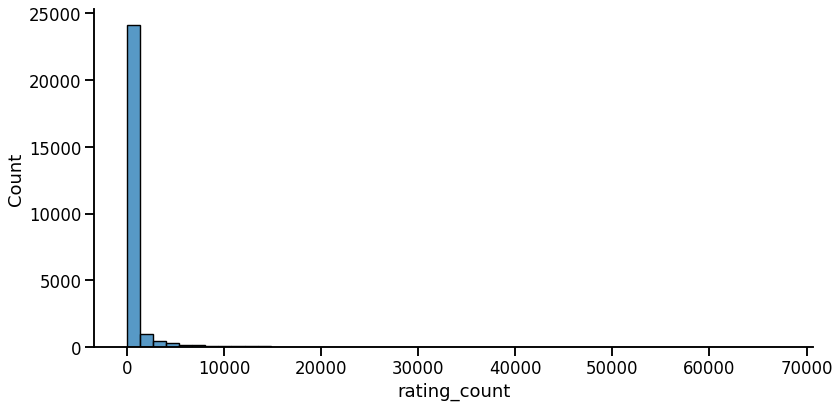

In [ ]:
# Let's view  histogra m of number of ratings - we can see majority of movies have just a few ratings!
import seaborn as sns
sns.set_context("talk")
sns.displot(data=ratings_stats, x="rating_count", bins=50, height=6, aspect=2)

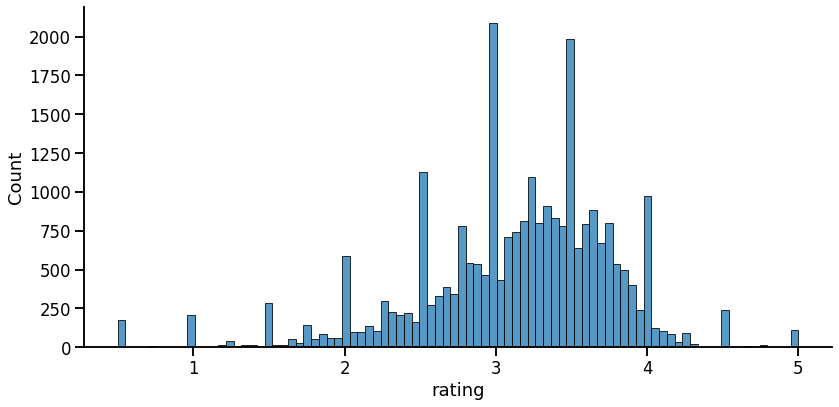

In [ ]:
# Let's check out the rating histogram
sns.displot(data=ratings_stats, x="rating", height=6, aspect=2)


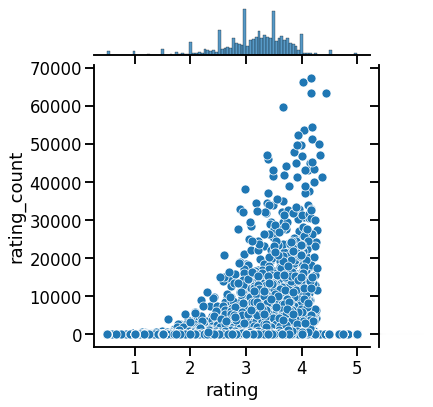

In [ ]:
# Let's look at the relationship between ratings and ratings count.
sns.jointplot(data=ratings_stats, x='rating',y='rating_count')

# This suggests a few things:
# (a) Movies with higher ratings tend to be rated more often
# (b) Extreme ratings (both high and low) tend to have just few ratings

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


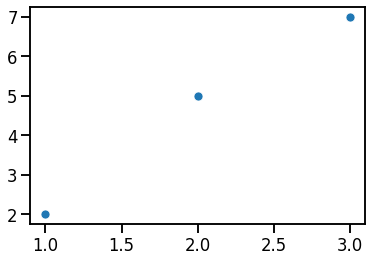

In [ ]:
sns.scatterplot([1,2,3],[2,5,7])

## Feature Engineering

In [3]:
user_n = len(ratings.userId.unique())
movie_n= len(ratings.movieId.unique())
print("unique users: ", user_n)
print("unique movies: ", movie_n)
print("Total no of entry in user_item matrix: {} Billion entries".format(user_n*movie_n/1000000000))

unique users:  138493
unique movies:  26744
Total no of entry in user_item matrix: 3.703856792 Billion entries


This is a huge dataset of **3.7B entries**!!!!!!, so we need to reduce user and movies otherwise our system may crash.... 



In [4]:
# Reducing user
# Taking only those users who have seen more than 500 movies

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 500)
print('user % retained: ',len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100)
print('Total no of users after reduction: ', len(ratings_f.userId.unique()))

user % retained:  5.40893763583719
Total no of users after reduction:  7491


In [5]:
# Reducing movies
# Taking only those movies which have been seen by more than 500 users

ratings_f = ratings_f.groupby('movieId').filter(lambda x: len(x) >= 500)
print("movies % retained: ",len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100)
print('Total no of movies after reduction: ', len(ratings_f.movieId.unique()))

movies % retained:  11.503775936652247
Total no of movies after reduction:  3138


In [7]:
# Filter the movie dataFrame 
movies_f = movies[movies.movieId.isin(ratings_f.movieId.tolist())]

In [40]:
# Just for Fun!! create a new DataFrame with popular movies and their ratings
ratings_expanded = pd.merge(ratings_f, movies_f, on="movieId")
top_movies = pd.DataFrame(ratings_expanded.groupby("title").mean()['rating'])
top_movies['rating_count'] = pd.DataFrame(ratings_expanded.groupby("title").count()["rating"])
movies_most_viewed = top_movies.sort_values(by='rating_count', ascending=False)
movies_top_rated = top_movies.sort_values(by='rating', ascending=False)

In [41]:
movies_most_viewed.head()

,rating,rating_count
title,,
"Matrix, The (1999)",4.146633,6980
Forrest Gump (1994),3.844184,6912
Jurassic Park (1993),3.603232,6868
Back to the Future (1985),3.933168,6853
Pulp Fiction (1994),4.256348,6813


In [42]:
movies_top_rated.head()

,rating,rating_count
title,,
"Godfather, The (1972)",4.402116,5813
"Shawshank Redemption, The (1994)",4.376952,6469
Band of Brothers (2001),4.336177,879
"Usual Suspects, The (1995)",4.289315,6130
"Godfather: Part II, The (1974)",4.288553,4857


Save the top_viewed and most_rated movies to drive(so that we can directly load it whenever needed, no need to recalculate again and again)

In [43]:
movies_most_viewed.to_csv(path+"movies_most_viewed.csv")
movies_top_rated.to_csv(path+"movies_top_rated.csv")

## **Content based Filtering** : converting each movie to a feature vecter, using the contents present in each movie

In [8]:
movies_f.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# We can use 'genres' as one of the feature for featurization
# Convert genres into standard form
movies_f['genres'] = movies_f['genres'].str.replace('|',' ')
movies_f.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


Is there any other features of the movie which we can use for featurization

In [11]:
tags.head(2)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18


Users have also given a tag for movies, so we can use this information

In [12]:
# Create a mixed dataFrame of movies containing genres and tags 
movie_genre_tag = pd.merge(movies_f, tags, on='movieId', how='left')
movie_genre_tag.head(3)


,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched,2014-12-04 23:44:40
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation,2007-07-08 13:59:15
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature,2007-07-08 22:21:47


we can use genres and tags as a feature for each movie, and each movie can be represented by a feature vector for content based filtering

In [16]:
# In movie_genre_tag, for each movieId there are multiple tags, so combine them

# (movie_genre_tag.isnull().sum()) is not zero so,
# Tackle the tags containing null/NA 
movie_genre_tag.fillna("", inplace=True)

movie_genre_tag = pd.DataFrame(movie_genre_tag.groupby('movieId')['tag'].apply(lambda x: '%s' % ' '.join(x)))
movie_genre_tag = pd.merge(movies_f, movie_genre_tag, on='movieId', how='left')
movie_genre_tag.head(2)

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...


In [17]:
# genres and tags both contains text data, so combine them into one feature

movie_genre_tag['metadata'] = movie_genre_tag[['genres', 'tag']].apply(lambda x:' '.join(x), axis=1)
movie_genre_tag.head(2)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy time travel adapted...


In [18]:
# drop unnecessary features

final_movie_content = movie_genre_tag.drop(['genres', 'tag'], axis=1)
final_movie_content.head() 

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy time travel adapted...
2,3,Grumpier Old Men (1995),Comedy Romance old people that is actually fun...
3,4,Waiting to Exhale (1995),Comedy Drama Romance chick flick revenge chara...
4,5,Father of the Bride Part II (1995),Comedy Diane Keaton family sequel Steve Martin...


In [19]:
final_movie_content.shape

(3138, 3)

**NLP:** for text data processing

Using **tf-idf** for converting text data to vector form

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final_movie_content['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=final_movie_content.index.tolist())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14989,14990,14991,14992,14993,14994,14995,14996,14997,14998
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dimensionaly of dataset is very large**, so we need to do dimensionality reduction

**SVD:** for dimensionality reduction

In [21]:
# dimensionality reduction using SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(tfidf_df)

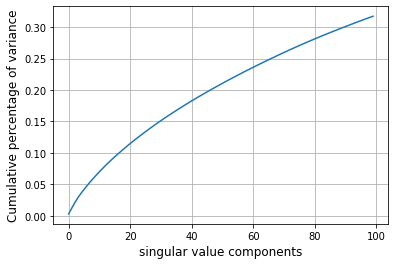

In [22]:
# Plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained)
plt.xlabel('singular value components', fontsize=12)
plt.ylabel('Cumulative percentage of variance', fontsize=12)
plt.grid()
plt.show()


## 35% variance is expalined using only 100 dimensions

In [23]:
# Our Final content Matrix:
latent_matrix_1_df = pd.DataFrame(latent_matrix, index=movies_f.title.tolist())
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),0.180040,-0.029719,0.179483,0.465407,-0.246470,-0.058342,0.024061,-0.125271,0.078734,0.013887,...,0.091696,0.091664,0.016792,-0.026353,-0.002998,-0.046109,-0.053364,0.083943,0.003471,-0.001196
Jumanji (1995),0.141094,-0.039408,0.135548,0.068259,-0.009774,-0.009361,-0.008108,0.023037,-0.066198,0.039569,...,-0.052091,-0.009348,-0.015720,0.023109,-0.026747,-0.008582,0.003931,-0.034096,-0.002687,-0.047484
Grumpier Old Men (1995),0.066663,-0.027616,-0.033621,0.038322,0.050502,0.014063,0.015080,-0.019161,-0.032380,-0.001651,...,0.023008,0.015770,0.012116,0.004720,-0.004897,0.018580,0.024279,-0.019704,0.031932,-0.030616
Waiting to Exhale (1995),0.126630,-0.021240,-0.087340,0.072905,0.070761,0.023068,0.021071,-0.000493,-0.092895,0.035933,...,0.012967,0.032633,-0.002741,0.037735,0.017784,-0.003748,-0.022222,-0.022524,-0.006854,-0.048106
Father of the Bride Part II (1995),0.130024,-0.046659,-0.058980,0.092096,0.077663,0.020429,0.033174,-0.006211,-0.046519,0.003642,...,-0.081979,0.036388,-0.026669,-0.039235,0.039293,0.033512,-0.033349,-0.025049,0.101289,0.019304


In [24]:
latent_matrix_1_df.shape

(3138, 100)

 **Saving the content matrix to drive**

In [25]:
latent_matrix_1_df.to_csv(path+"Trained_content_matrix.csv")

## **Collaborative Filtering:** Using user ratings to create **item-item** based collaborative filtering Recomendation System

In [26]:
ratings_f.head()

,userId,movieId,rating,timestamp
960,11,1,4.5,2009-01-02 01:13:41
961,11,10,2.5,2009-01-02 01:15:59
962,11,19,3.5,2009-01-01 04:21:44
963,11,32,5.0,2009-01-01 04:11:35
964,11,39,4.5,2009-01-02 01:17:12


In [27]:
movies_f.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
# Creating item-user matrix

movie_user_mat = ratings_f.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,11,24,54,58,91,104,116,134,156,208,...,138270,138301,138307,138325,138382,138397,138406,138411,138437,138474
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.5,4.0,4.0,5.0,4.0,0.0,3.0,4.0,5.0,4.0,...,0.0,2.5,3.5,5.0,3.0,0.0,4.0,5.0,4.0,5.0
2,0.0,0.0,3.0,0.0,3.5,0.0,2.0,0.0,5.0,0.0,...,0.0,2.5,2.5,3.0,4.0,0.0,3.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


**Dimensionaly of dataset is very large**, so we need to do dimensionality reduction

**SVD:** for dimensionality reduction

In [29]:
# dimensionality reduction using SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix_2 = svd.fit_transform(movie_user_mat)

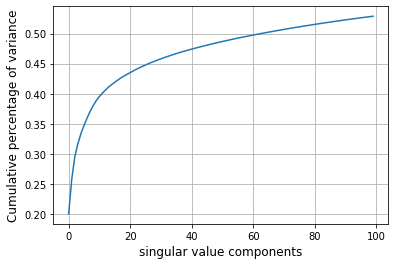

In [30]:
# Plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained)
plt.xlabel('singular value components', fontsize=12)
plt.ylabel('Cumulative percentage of variance', fontsize=12)
plt.grid()
plt.show()


## 55% variance is expalined using only 100 dimensions

In [31]:
# Our Final item-user Matrix:
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movies_f.title.tolist())
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),282.536686,6.816792,-18.585359,-9.663804,-10.364832,59.364696,17.815873,-15.457720,0.175331,8.821125,...,-2.162573,6.672231,5.041462,-4.368624,0.518264,-5.279075,-5.634703,-1.401260,-6.825213,-5.091163
Jumanji (1995),160.335852,35.603744,-41.767050,-9.981951,-22.336570,27.036077,3.816848,-1.931655,-18.559956,21.741900,...,-3.939944,1.240177,5.124781,-3.576353,-5.722931,3.068576,1.258166,0.079730,5.362797,-3.386203
Grumpier Old Men (1995),79.134740,-6.145754,-39.873735,-17.139839,-0.160426,-6.148283,-0.858873,-9.741733,10.495426,20.197653,...,6.141081,2.226431,0.830733,2.988697,7.758507,3.039848,2.701913,-1.177507,4.569800,0.745888
Waiting to Exhale (1995),20.404162,-14.381212,-6.370951,-14.540339,1.271769,-4.273144,-3.314943,-9.332595,-9.976462,2.039482,...,2.591723,2.244253,0.306654,0.453643,1.477697,-1.520486,-0.706846,-0.722165,0.102871,-2.313679
Father of the Bride Part II (1995),65.954870,-2.622380,-33.489965,-31.520951,-2.698947,0.521843,-4.069042,-7.353641,-1.776220,16.673502,...,1.941145,1.905989,-3.216807,2.426689,4.706430,5.497719,-5.427118,-1.193490,0.397793,4.102112


In [32]:
latent_matrix_2_df.shape

(3138, 100)

**Saving the item-user matrix to drive**

In [33]:
latent_matrix_2_df.to_csv(path+"Trained_item_user_matrix.csv")

## **Recomend the movies:** using content, collaborative and Hybrid cosine Similarity

In [45]:
# Loading the Trained Model
latent_matrix_1_df = pd.read_csv(path+"Trained_content_matrix.csv").set_index('Unnamed: 0')
latent_matrix_2_df = pd.read_csv(path+"Trained_item_user_matrix.csv").set_index('Unnamed: 0')
movies_title_most_viewed = pd.read_csv(path+"movies_most_viewed.csv")

In [46]:
# Defining the function for recomending the movies

from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(title):

    # Take the latent vectors for a selected movie from both content and collaborative matrix
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # Calculate the similarity of the movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # An average measure of both content and collaborative
    hybrid = (score_1+score_2)/2.0

    # Form a DataFrame of similar movies
    dictDf = {'content-sim': score_1, 'collaborative-sim': score_2, 'hybrid': hybrid}
    similar = pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

    # Sort it on the basis of either: content, collaborative or hybrid
    # Here: hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    return similar.head(11)

### **Movies Title:** Sorted by most viewed

In [51]:
pd.set_option('display.max_rows', None)
print("\nTotal Top Movies available: {}\n\n".format(movies_title_most_viewed.shape[0]))
movies_title_most_viewed


Total Top Movies available: 3138




,title,rating,rating_count
0,"Matrix, The (1999)",4.146633,6980
1,Forrest Gump (1994),3.844184,6912
2,Jurassic Park (1993),3.603232,6868
3,Back to the Future (1985),3.933168,6853
4,Pulp Fiction (1994),4.256348,6813
5,"Silence of the Lambs, The (1991)",4.165287,6764
6,Men in Black (a.k.a. MIB) (1997),3.487776,6749
7,Star Wars: Episode IV - A New Hope (1977),4.187341,6699
8,Raiders of the Lost Ark (Indiana Jones and the...,4.247453,6674
9,Star Wars: Episode V - The Empire Strikes Back...,4.197113,6651


## **Enter the Movie Title for recomendations**

In [52]:
recommend_movies("Matrix, The (1999)")

,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
"Matrix, The (1999)",1.000000,1.000000,1.000000
"Matrix Reloaded, The (2003)",0.940408,0.885158,0.912783
"Matrix Revolutions, The (2003)",0.924997,0.828809,0.876903
Tron (1982),0.760246,0.815375,0.787811
Dark City (1998),0.703966,0.837191,0.770579
Strange Days (1995),0.773032,0.736370,0.754701
Blade Runner (1982),0.581970,0.922691,0.752330
Johnny Mnemonic (1995),0.725449,0.766918,0.746184
Gattaca (1997),0.556418,0.924485,0.740451


In [53]:
recommend_movies("Silence of the Lambs, The (1991)")


,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
"Silence of the Lambs, The (1991)",1.000000,1.000000,1.000000
Hannibal (2001),0.901181,0.809071,0.855126
"Talented Mr. Ripley, The (1999)",0.646896,0.858911,0.752904
Seven (a.k.a. Se7en) (1995),0.526993,0.969668,0.748330
Manhunter (1986),0.864160,0.629697,0.746928
Red Dragon (2002),0.691158,0.766705,0.728931
Natural Born Killers (1994),0.574675,0.865066,0.719871
American Psycho (2000),0.629129,0.809164,0.719146
Summer of Sam (1999),0.775431,0.661991,0.718711


In [54]:
recommend_movies("Toy Story (1995)")

,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.982819,0.965362,0.974090
"Bug's Life, A (1998)",0.944267,0.954001,0.949134
"Monsters, Inc. (2001)",0.935150,0.908628,0.921889
Finding Nemo (2003),0.940125,0.881353,0.910739
Ice Age (2002),0.935723,0.811701,0.873712
Antz (1998),0.824072,0.891218,0.857645
"Incredibles, The (2004)",0.850215,0.845895,0.848055
Ratatouille (2007),0.941612,0.686521,0.814067


In [55]:
recommend_movies("Fight Club (1999)")

,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
Fight Club (1999),1.000000,1.000000,1.000000
American History X (1998),0.676116,0.956651,0.816384
Snatch (2000),0.631819,0.928073,0.779946
Seven (a.k.a. Se7en) (1995),0.570951,0.969741,0.770346
Memento (2000),0.570606,0.948741,0.759673
Primal Fear (1996),0.713807,0.713288,0.713548
Being John Malkovich (1999),0.466685,0.917758,0.692222
"Sixth Sense, The (1999)",0.443803,0.940484,0.692143
American Beauty (1999),0.420414,0.954383,0.687399


We can use the similarity information from item-item collaborative filtering to compute a rating prediction ***r[i][u]***, for an ***item(i)*** by a ***user(u)*** where the rating is missing. By taking a weighted average on the ratings of the top K nearest neighbours of item(i) which is already seen by user(u)